In [1]:
import random
import csv
import matplotlib.pyplot as plt

In [5]:
def generate_grid(n, m, default_density=(1, 0), csv_filename=None):
    #n is dimension of square grid, m is number of areas of different types to generate
    # Create an empty grid
    grid = [[None] * n for _ in range(n)]

    # Define the area types
    area_types = [
        {'housing_density': 1, 'vegetation_density': 0},
        {'housing_density': 1, 'vegetation_density': 1},
        {'housing_density': 2, 'vegetation_density': 0},
        {'housing_density': 2, 'vegetation_density': 1},
        {'housing_density': 3, 'vegetation_density': 0},
        {'housing_density': 3, 'vegetation_density': 1},
        {'housing_density': 4, 'vegetation_density': 0},
        {'housing_density': 4, 'vegetation_density': 1},
        {'housing_density': 5, 'vegetation_density': 0},
        {'housing_density': 5, 'vegetation_density': 1}
    ]

    # Create m rectangular areas
    for _ in range(m):
        area_type = random.choice(area_types)
        area_width = random.randint(1, n // 3)  # Random width (at most 1/3 of n)
        area_height = random.randint(1, n // 3)  # Random height (at most 1/3 of n)
        start_row = random.randint(0, n - area_height)  # Random starting row index
        start_col = random.randint(0, n - area_width)  # Random starting column index

        # Assign the area type to the grid cells
        for i in range(start_row, start_row + area_height):
            for j in range(start_col, start_col + area_width):
                grid[i][j] = area_type

    # Fill in the remaining cells with the default area type
    default_area = {'housing_density': default_density[0], 'vegetation_density': default_density[1]}
    for i in range(n):
        for j in range(n):
            if grid[i][j] is None:
                grid[i][j] = default_area

    # Generate CSV data
    csv_data = []
    node_id = 1
    for i in range(n):
        for j in range(n):
            area = grid[i][j]
            
            #coordinates are assigned as centers of cells
            x_coordinate = j + 0.5
            y_coordinate = i + 0.5
            
            #value at start is assigned to be higher as housing density increases
            housing_density = area['housing_density']
            if housing_density == 1:
                value_at_start = 0.1
            elif housing_density == 2:
                value_at_start = 0.2
            elif housing_density == 3:
                value_at_start = 0.4
            elif housing_density == 4:
                value_at_start = 0.8
            elif housing_density == 5:
                value_at_start = 1.0
                
            #"veg" is randomly assigned to be b/w 0 and 0.5 if vegetation density is 0, and b/w 0.5 and 1 otherwise
            vegetation_density = area['vegetation_density']
            if vegetation_density == 0:
                veg = round(random.uniform(0, 0.5), 2)
            else:
                veg = round(random.uniform(0.5, 1), 2)
                
            #then, fire degradation rate and fire amelioration rate are assigned based on veg; higher veg - faster fire
            fire_degradation_rate = round(random.uniform(veg-0.1, veg+0.1), 2) #value b/w 0 and 1
            fire_amelioration_rate = round(random.uniform(veg-0.1, veg+0.1), 2)/2 #value b/w 0 and 0.5
            if fire_degradation_rate > 1:
                fire_degradation_rate = 1
            elif fire_degradation_rate < 0:
                fire_degradation_rate = 0
            if fire_amelioration_rate > 0.5:
                fire_amelioration_rate = 0.5
            elif fire_amelioration_rate < 0:
                fire_amelioration_rate = 0
            
            #value degradation is also assigned based on the above rates: faster the fire, faster the value deteriorates
            value_degradation_rate = (fire_amelioration_rate + fire_degradation_rate)/10 #value between 0 and 0.15

            neighborhood_list = []
            if i > 0:
                neighborhood_list.append((i - 1) * n + j + 1)  # Above cell
            if i < n - 1:
                neighborhood_list.append((i + 1) * n + j + 1)  # Below cell
            if j > 0:
                neighborhood_list.append(i * n + j)  # Left cell
            if j < n - 1:
                neighborhood_list.append(i * n + j + 2)  # Right cell

            csv_data.append([
                node_id, x_coordinate, y_coordinate, value_at_start,
                value_degradation_rate, fire_degradation_rate,
                fire_amelioration_rate, neighborhood_list
            ])

            node_id += 1

    # Write CSV file
    if csv_filename:
        with open(csv_filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                'node_id', 'x_coordinate', 'y_coordinate', 'value_at_start',
                'value_degradation_rate', 'fire_degradation_rate',
                'fire_amelioration_rate', 'neighborhood_list'
            ])
            writer.writerows(csv_data)

    # Plot the grid
    plt.figure(figsize=(6, 6))
    plt.imshow([[area['housing_density'] for area in row] for row in grid], cmap='YlGnBu', vmin=1, vmax=5)
    plt.colorbar(label='Housing Density')
    veg = [[None] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            veg[i][j] = int(grid[i][j]['vegetation_density'] > 0)
    for i in range(n):
        for j in range(n):
            plt.annotate(veg[i][j], xy=(j, i), ha='center', va='center')

    plt.title('Density Grid')
    plt.show()


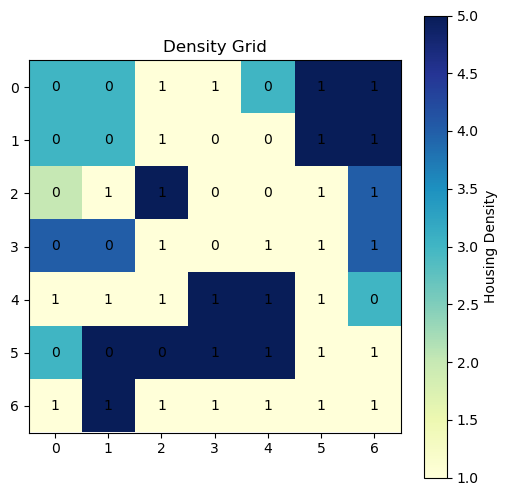

In [6]:
generate_grid(7, 20, default_density=(1, 1), csv_filename='WUI_scenario.csv')